In [1]:
# Initial Setup

# Import necessary libraries
import os
import random
import numpy as np
import pandas as pd
import torch
from transformers import BertTokenizer, BertForSequenceClassification, AdamW
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, roc_auc_score, confusion_matrix
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import nltk
import logging

In [2]:
# Configure logging
logging.basicConfig(level=logging.INFO, format="%(asctime)s - %(levelname)s - %(message)s")

In [3]:
# Download NLTK resources
nltk.download("stopwords")
nltk.download("wordnet")

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\hd6140q\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\hd6140q\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [4]:
# Detect device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
logging.info(f"Using device: {device}")

2024-11-22 10:59:25,478 - INFO - Using device: cuda


In [5]:
# Global configuration settings
config = {
    "batch_size": 16,                  # Batch size for DataLoader
    "max_seq_length": 128,            # Maximum sequence length for BERT
    "num_epochs": 3,                  # Number of training epochs
    "learning_rate": 2e-5,            # Learning rate for optimizer
    "checkpoint_dir": "checkpoints",  # Directory to save model checkpoints
    "seed": 42,                       # Random seed for reproducibility
    "dataset_path": "dataset.csv",    # Path to the dataset
    "model_name": "bert-base-uncased" # Pre-trained BERT model
}

In [6]:
# Create checkpoint directory with error handling
try:
    os.makedirs(config["checkpoint_dir"], exist_ok=True)
    logging.info(f"Checkpoint directory created at: {config['checkpoint_dir']}")
except Exception as e:
    logging.error(f"Error creating checkpoint directory: {e}")

2024-11-22 10:59:25,517 - INFO - Checkpoint directory created at: checkpoints


In [7]:
# Set random seed for reproducibility
random.seed(config["seed"])
np.random.seed(config["seed"])
torch.manual_seed(config["seed"])
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(config["seed"])

logging.info("Environment setup complete.")

2024-11-22 10:59:25,524 - INFO - Environment setup complete.


In [8]:
# Data Loading and Preprocessing

import pandas as pd
import re
from sklearn.model_selection import train_test_split
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import logging

In [9]:
# Configure logging
logging.basicConfig(level=logging.INFO, format="%(asctime)s - %(levelname)s - %(message)s")

# Preprocessing utilities
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words("english"))

In [10]:
# Load dataset
def load_dataset(file_path):
    """
    Load the dataset from a CSV file and retain relevant columns.
    """
    try:
        df = pd.read_csv(file_path)
        # Retain only the 'text' and 'airline_sentiment' columns
        df = df[["text", "airline_sentiment"]]
        # Map sentiment labels to numerical values
        df["airline_sentiment"] = df["airline_sentiment"].map({"positive": 2, "neutral": 1, "negative": 0})
        logging.info(f"Dataset loaded with {len(df)} records.")
        # Drop rows with missing values
        df = df.dropna()
        return df
    except Exception as e:
        logging.error(f"Error loading dataset: {e}")
        return None

In [11]:
# Clean tweets
def clean_tweet(tweet):
    """
    Preprocess and clean the text by removing unwanted patterns.
    """
    # Remove URLs
    tweet = re.sub(r"http\S+|www\S+", "", tweet)
    # Remove mentions and hashtags
    tweet = re.sub(r"@\S+|#\S+", "", tweet)
    # Remove special characters and numbers
    tweet = re.sub(r"[^A-Za-z\s]", "", tweet)
    # Convert to lowercase
    return tweet.lower()

In [12]:
# Stopword removal and lemmatization
def preprocess_text(tweet):
    """
    Remove stopwords and apply lemmatization.
    """
    words = tweet.split()
    words = [lemmatizer.lemmatize(word) for word in words if word not in stop_words]
    return " ".join(words)

In [13]:
# Apply preprocessing to the entire dataset
def preprocess_dataset(df):
    """
    Apply cleaning and preprocessing to the dataset.
    """
    df["cleaned_text"] = df["text"].apply(clean_tweet)
    df["processed_text"] = df["cleaned_text"].apply(preprocess_text)
    return df

In [14]:
# Visualizations
def plot_sentiment_distribution(df):
    """
    Plot the distribution of sentiments in the dataset with percentage labels.
    """
    sentiment_counts = df["airline_sentiment"].value_counts(normalize=True) * 100
    sentiment_labels = {2: "Positive", 1: "Neutral", 0: "Negative"}
    sentiment_counts.index = [sentiment_labels[idx] for idx in sentiment_counts.index]

    plt.figure(figsize=(8, 6))
    sentiment_counts.plot(kind="bar", color=["green", "blue", "red"], alpha=0.7)
    plt.title("Sentiment Distribution", fontsize=14)
    plt.ylabel("Percentage of Samples", fontsize=12)
    plt.xlabel("Sentiment", fontsize=12)
    plt.xticks(rotation=0, fontsize=10)

    for i, value in enumerate(sentiment_counts):
        plt.text(i, value, f"{value:.1f}%", ha="center", va="bottom", fontsize=10)
    
    plt.show()

def generate_wordcloud(text_data):
    """
    Generate and display a word cloud for the given text data.
    """
    wordcloud = WordCloud(width=800, height=400, background_color="white").generate(" ".join(text_data))
    plt.figure(figsize=(10, 8))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.title("Word Cloud of Processed Text", fontsize=16)
    plt.show()

In [15]:
# Train-test split
def split_dataset(df):
    """
    Split the dataset into training and testing sets.
    """
    train_texts, test_texts, train_labels, test_labels = train_test_split(
        df["processed_text"], df["airline_sentiment"], test_size=0.2, random_state=42, stratify=df["airline_sentiment"]
    )
    # Reset indices for compatibility with PyTorch DataLoader
    train_texts = train_texts.reset_index(drop=True)
    test_texts = test_texts.reset_index(drop=True)
    train_labels = train_labels.reset_index(drop=True)
    test_labels = test_labels.reset_index(drop=True)
    logging.info(f"Train-test split completed. Training samples: {len(train_texts)}, Test samples: {len(test_texts)}")
    return train_texts, test_texts, train_labels, test_labels

2024-11-22 10:59:25,813 - INFO - Dataset loaded with 14640 records.


First 5 rows of the cleaned dataset:
                                                text  \
0                @VirginAmerica What @dhepburn said.   
1  @VirginAmerica plus you've added commercials t...   
2  @VirginAmerica I didn't today... Must mean I n...   
3  @VirginAmerica it's really aggressive to blast...   
4  @VirginAmerica and it's a really big bad thing...   

                                        cleaned_text  \
0                                         what  said   
1   plus youve added commercials to the experienc...   
2   i didnt today must mean i need to take anothe...   
3   its really aggressive to blast obnoxious ente...   
4            and its a really big bad thing about it   

                                      processed_text  airline_sentiment  
0                                               said                  1  
1       plus youve added commercial experience tacky                  2  
2       didnt today must mean need take another trip               

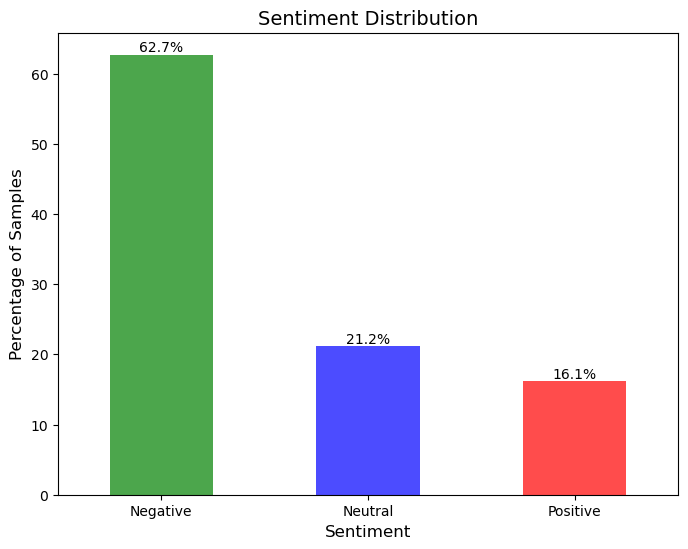

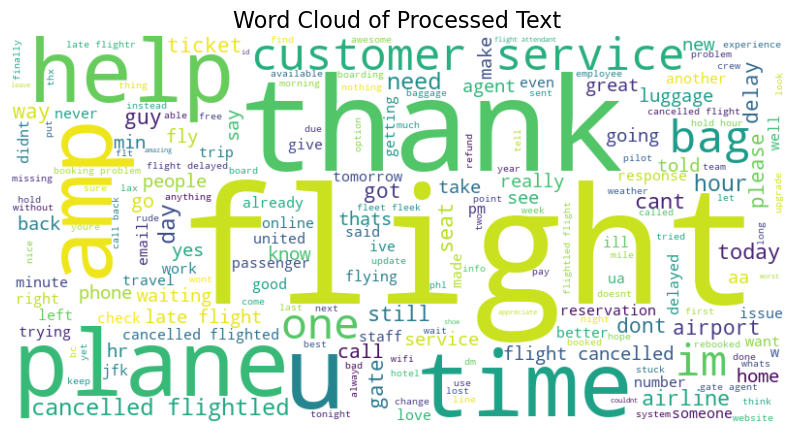

2024-11-22 10:59:28,162 - INFO - Train-test split completed. Training samples: 11712, Test samples: 2928


In [16]:
# Main execution
file_path = "C:/Users/hd6140q/Downloads/Tweets.csv"  # Replace with your dataset path
df = load_dataset(file_path)
if df is not None:
    df = preprocess_dataset(df)
    print("First 5 rows of the cleaned dataset:")
    print(df[["text", "cleaned_text", "processed_text", "airline_sentiment"]].head())

    # Visualizations
    plot_sentiment_distribution(df)
    generate_wordcloud(df["processed_text"])

    # Train-test split
    train_texts, test_texts, train_labels, test_labels = split_dataset(df)

In [17]:
# Tokenization and Dataset Preparation

from transformers import BertTokenizer
from torch.utils.data import Dataset, DataLoader
import torch

# Load the BERT tokenizer
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

In [18]:
# Custom PyTorch dataset class
class TwitterDataset(Dataset):
    """
    Custom Dataset class for Twitter sentiment analysis.
    """
    def __init__(self, texts, labels, tokenizer, max_length):
        """
        Initialize the dataset with texts, labels, tokenizer, and max sequence length.
        """
        self.texts = texts.tolist()  # Ensure compatibility with PyTorch DataLoader
        self.labels = labels.tolist()
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        """
        Return the number of samples in the dataset.
        """
        return len(self.texts)

    def __getitem__(self, idx):
        """
        Return a tokenized sample at the given index.
        """
        text = self.texts[idx]
        label = self.labels[idx]

        # Tokenize the text
        encoding = self.tokenizer(
            text,
            max_length=self.max_length,
            padding="max_length",
            truncation=True,
            return_tensors="pt",
        )

        return {
            "input_ids": encoding["input_ids"].squeeze(0),
            "attention_mask": encoding["attention_mask"].squeeze(0),
            "labels": torch.tensor(label, dtype=torch.long),
        }

In [19]:
# Prepare the datasets and DataLoaders
def prepare_datasets(train_texts, test_texts, train_labels, test_labels, tokenizer, max_length):
    """
    Prepare PyTorch datasets and dataloaders for training and testing.
    """
    train_dataset = TwitterDataset(train_texts, train_labels, tokenizer, max_length)
    test_dataset = TwitterDataset(test_texts, test_labels, tokenizer, max_length)

    train_loader = DataLoader(train_dataset, batch_size=config["batch_size"], shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=config["batch_size"], shuffle=False)

    return train_loader, test_loader

In [20]:
# Tokenization parameters
max_length = config["max_seq_length"]

# Prepare dataloaders
train_loader, test_loader = prepare_datasets(
    train_texts, test_texts, train_labels, test_labels, tokenizer, max_length
)

In [21]:
# Analyze a batch of data
def analyze_batch(loader):
    """
    Analyze and print the structure of a sample batch from the DataLoader.
    """
    batch = next(iter(loader))
    print("Sample input batch from DataLoader:")
    print(f"Input IDs shape: {batch['input_ids'].shape}")
    print(f"Attention Mask shape: {batch['attention_mask'].shape}")
    print(f"Labels shape: {batch['labels'].shape}")
    print("First input IDs example:", batch["input_ids"][0])
    print("First attention mask example:", batch["attention_mask"][0])
    print("First label:", batch["labels"][0])

# Analyze a batch of training data
analyze_batch(train_loader)

Sample input batch from DataLoader:
Input IDs shape: torch.Size([16, 128])
Attention Mask shape: torch.Size([16, 128])
Labels shape: torch.Size([16])
First input IDs example: tensor([  101, 19907, 10747, 10930,  3566,  2362,  6927,  3917,  5216,   102,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,   

In [22]:
# Model Definition

from transformers import BertForSequenceClassification
import torch

# Function to create the model
def create_model(num_labels=3, pretrained_model_name="bert-base-uncased"):
    """
    Create and initialize the BERT model for sequence classification.
    
    Args:
    - num_labels (int): Number of output classes for classification (default: 3).
    - pretrained_model_name (str): Name of the pre-trained BERT model to use (default: "bert-base-uncased").
    
    Returns:
    - model: Initialized BERT model for sequence classification.
    """
    print("Initializing the BERT model for sequence classification...")
    
    # Load pre-trained BERT with a classification head
    model = BertForSequenceClassification.from_pretrained(
        pretrained_model_name,
        num_labels=num_labels,  # Number of sentiment classes
        output_attentions=False,  # No attention weights required
        output_hidden_states=False,  # No hidden states required
    )
    
    # Move model to the appropriate device (GPU/CPU)
    model.to(device)
    print(f"Model initialized and moved to {device}.")
    return model

In [23]:
# Function to count trainable parameters
def count_trainable_parameters(model):
    """
    Count the number of trainable parameters in the model.
    """
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    total_params = sum(p.numel() for p in model.parameters())
    print(f"Total Parameters: {total_params:,}")
    print(f"Trainable Parameters: {trainable_params:,}")

In [24]:
# Function to freeze certain BERT layers
def freeze_bert_layers(model, freeze_layers=True, num_layers_to_freeze=12):
    """
    Optionally freeze the initial BERT layers for efficient fine-tuning.
    
    Args:
    - model: The BERT model to modify.
    - freeze_layers (bool): Whether to freeze layers or not.
    - num_layers_to_freeze (int): Number of initial layers to freeze (default: 12 for full BERT).
    
    Returns:
    - model: Modified BERT model with layers frozen if specified.
    """
    if freeze_layers:
        print(f"Freezing the first {num_layers_to_freeze} BERT layers...")
        for name, param in model.bert.named_parameters():
            # Freeze specified layers
            if name.startswith("encoder.layer") and int(name.split(".")[2]) < num_layers_to_freeze:
                param.requires_grad = False
        print("Layers frozen successfully.")
    else:
        print("No layers frozen.")
    return model

# Function to print model architecture
def display_model_summary(model):
    """
    Print the architecture of the model.
    """
    print("\nModel architecture:")
    print(model)

In [25]:
# Initialize the model
num_labels = 3  # Three sentiment classes: positive, neutral, negative
model = create_model(num_labels=num_labels)

# Freeze the first 10 layers of the BERT encoder for fine-tuning efficiency
model = freeze_bert_layers(model, freeze_layers=True, num_layers_to_freeze=10)

# Display model summary
display_model_summary(model)

# Display trainable parameters
count_trainable_parameters(model)

Initializing the BERT model for sequence classification...


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model initialized and moved to cuda.
Freezing the first 10 BERT layers...
Layers frozen successfully.

Model architecture:
BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
    

In [26]:
# Training Loop

from torch.optim import AdamW
from transformers import get_scheduler
import torch
from tqdm import tqdm

In [27]:
def train_model(model, train_loader, test_loader, device, config):
    """
    Train the BERT model on the training dataset and evaluate on the test dataset.
    
    Args:
    - model: BERT model for sequence classification.
    - train_loader: DataLoader for training data.
    - test_loader: DataLoader for testing data.
    - device: The device to run the training on (CPU/GPU).
    - config: Configuration dictionary with training parameters.
    
    Returns:
    - training_stats: List of dictionaries containing training and validation loss for each epoch.
    """
    # Define optimizer and learning rate scheduler
    optimizer = AdamW(model.parameters(), lr=config["learning_rate"])
    num_training_steps = len(train_loader) * config["num_epochs"]
    scheduler = get_scheduler("linear", optimizer=optimizer, num_warmup_steps=0, num_training_steps=num_training_steps)
    
    # Define loss function
    loss_fn = torch.nn.CrossEntropyLoss()
    
    # Initialize stats tracking
    training_stats = []
    
    # Training loop
    print("\nStarting training...")
    for epoch in range(config["num_epochs"]):
        print(f"\nEpoch {epoch + 1}/{config['num_epochs']}")

        # Set model to training mode
        model.train()
        total_loss = 0
        progress_bar = tqdm(train_loader, desc="Training", leave=False)
        
        for batch in progress_bar:
            # Move data to the appropriate device
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["labels"].to(device)
            
            # Forward pass
            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            total_loss += loss.item()
            
            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            
            # Gradient clipping
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            
            optimizer.step()
            scheduler.step()
            
            # Update progress bar
            progress_bar.set_postfix(loss=loss.item())
        
        # Calculate average loss for the epoch
        avg_train_loss = total_loss / len(train_loader)
        
        # Evaluate on the validation set
        val_loss, val_accuracy = evaluate_model(model, test_loader, device, loss_fn)
        
        # Save checkpoint
        checkpoint_path = f"{config['checkpoint_dir']}/bert_epoch_{epoch + 1}.pt"
        torch.save(model.state_dict(), checkpoint_path)
        
        # Log epoch stats
        training_stats.append({
            "epoch": epoch + 1,
            "train_loss": avg_train_loss,
            "val_loss": val_loss,
            "val_accuracy": val_accuracy,
        })
        print(f"Epoch {epoch + 1} completed. Train Loss: {avg_train_loss:.4f}, Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}")
        print(f"Checkpoint saved: {checkpoint_path}")
    
    print("Training completed.")
    return training_stats

In [28]:
def evaluate_model(model, loader, device, loss_fn):
    """
    Evaluate the model on the validation dataset.
    
    Args:
    - model: Trained BERT model.
    - loader: DataLoader for validation data.
    - device: The device to run the evaluation on (CPU/GPU).
    - loss_fn: Loss function used during training.
    
    Returns:
    - avg_loss: Average loss on the validation set.
    - accuracy: Accuracy on the validation set.
    """
    model.eval()
    total_loss = 0
    correct_predictions = 0
    total_samples = 0
    
    with torch.no_grad():
        for batch in loader:
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["labels"].to(device)
            
            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            total_loss += loss.item()
            
            # Compute predictions
            logits = outputs.logits
            predictions = torch.argmax(logits, dim=-1)
            correct_predictions += (predictions == labels).sum().item()
            total_samples += labels.size(0)
    
    avg_loss = total_loss / len(loader)
    accuracy = correct_predictions / total_samples
    return avg_loss, accuracy

In [29]:
# Call the training function
training_stats = train_model(model, train_loader, test_loader, device, config)

# Display training stats
for stat in training_stats:
    print(stat)


Starting training...

Epoch 1/3


Epoch 1 completed. Train Loss: 0.6490, Val Loss: 0.5503, Val Accuracy: 0.7763
Checkpoint saved: checkpoints/bert_epoch_1.pt

Epoch 2/3


Epoch 2 completed. Train Loss: 0.5295, Val Loss: 0.5305, Val Accuracy: 0.7930
Checkpoint saved: checkpoints/bert_epoch_2.pt

Epoch 3/3


Epoch 3 completed. Train Loss: 0.4907, Val Loss: 0.5297, Val Accuracy: 0.7947
Checkpoint saved: checkpoints/bert_epoch_3.pt
Training completed.
{'epoch': 1, 'train_loss': 0.648985111994333, 'val_loss': 0.5503423099960786, 'val_accuracy': 0.7762978142076503}
{'epoch': 2, 'train_loss': 0.5295296521256856, 'val_loss': 0.5305473160385434, 'val_accuracy': 0.7930327868852459}
{'epoch': 3, 'train_loss': 0.49070912695240454, 'val_loss': 0.5297253626129015, 'val_accuracy': 0.79474043715847}


In [30]:
# Evaluation

from sklearn.metrics import accuracy_score, precision_recall_fscore_support, roc_auc_score, confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import torch

In [31]:
def evaluate_model_with_class_report(model, test_loader, device, num_classes=3):
    """
    Evaluate the model on the test dataset and compute metrics, including class-wise breakdown.
    
    Args:
    - model: Trained BERT model for classification.
    - test_loader: DataLoader for test data.
    - device: The device to run the evaluation on (CPU/GPU).
    - num_classes (int): Number of output classes.
    
    Returns:
    - true_labels: List of true labels.
    - predictions: List of predicted labels.
    """
    model.eval()  # Set model to evaluation mode
    predictions = []
    true_labels = []
    
    with torch.no_grad():  # Disable gradient computation
        for batch in test_loader:
            # Move data to the appropriate device
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["labels"].to(device)
            
            # Forward pass
            outputs = model(input_ids, attention_mask=attention_mask)
            logits = outputs.logits  # Extract logits
            preds = torch.argmax(logits, axis=1)  # Get predicted class
            
            predictions.extend(preds.cpu().numpy())
            true_labels.extend(labels.cpu().numpy())
    
    # Compute overall metrics
    accuracy = accuracy_score(true_labels, predictions)
    precision, recall, f1, _ = precision_recall_fscore_support(true_labels, predictions, average="weighted")
    try:
        roc_auc = roc_auc_score(
            true_labels, 
            torch.nn.functional.one_hot(torch.tensor(predictions), num_classes=num_classes), 
            multi_class="ovr"
        )
    except ValueError:
        roc_auc = "ROC-AUC cannot be computed for single-class predictions."

    print("\nOverall Evaluation Metrics:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-Score: {f1:.4f}")
    print(f"ROC-AUC Score: {roc_auc}")
    
    # Class-wise metrics
    print("\nClass-wise Evaluation Metrics:")
    print(classification_report(true_labels, predictions, target_names=["Negative", "Neutral", "Positive"]))
    
    return true_labels, predictions

In [32]:
def plot_confusion_matrix(true_labels, predictions):
    """
    Plot the confusion matrix.
    """
    cm = confusion_matrix(true_labels, predictions)
    class_names = ["Negative", "Neutral", "Positive"]
    
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.show()

In [33]:
def plot_metric_curve(true_labels, predictions):
    """
    Plot Precision-Recall or ROC-AUC curves if applicable.
    """
    from sklearn.metrics import precision_recall_curve, roc_curve, auc
    true_one_hot = torch.nn.functional.one_hot(torch.tensor(true_labels), num_classes=3)
    pred_one_hot = torch.nn.functional.one_hot(torch.tensor(predictions), num_classes=3)
    
    # Precision-Recall Curve
    plt.figure(figsize=(10, 6))
    for i, label in enumerate(["Negative", "Neutral", "Positive"]):
        precision, recall, _ = precision_recall_curve(true_one_hot[:, i], pred_one_hot[:, i])
        plt.plot(recall, precision, label=f"Precision-Recall Curve ({label})")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title("Precision-Recall Curve")
    plt.legend()
    plt.show()

In [34]:
# Evaluate the model and compute metrics
true_labels, predictions = evaluate_model_with_class_report(model, test_loader, device)


Overall Evaluation Metrics:
Accuracy: 0.7947
Precision: 0.7887
Recall: 0.7947
F1-Score: 0.7908
ROC-AUC Score: 0.7944083554748887

Class-wise Evaluation Metrics:
              precision    recall  f1-score   support

    Negative       0.85      0.90      0.87      1835
     Neutral       0.65      0.57      0.61       620
    Positive       0.73      0.69      0.71       473

    accuracy                           0.79      2928
   macro avg       0.74      0.72      0.73      2928
weighted avg       0.79      0.79      0.79      2928



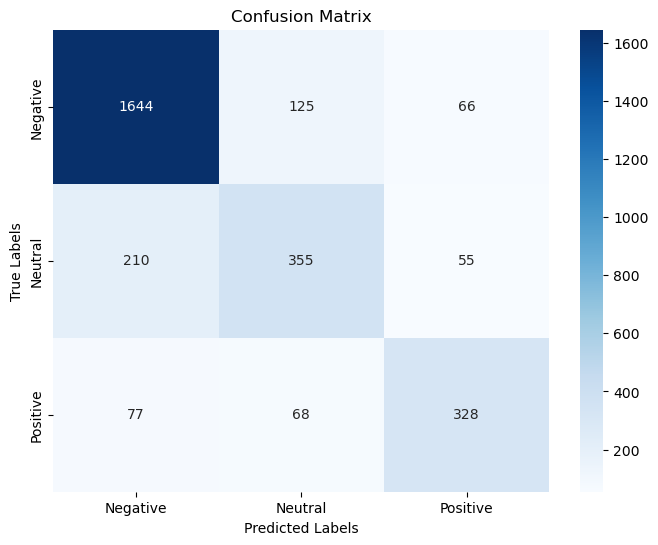

In [35]:
# Plot the confusion matrix
plot_confusion_matrix(true_labels, predictions)

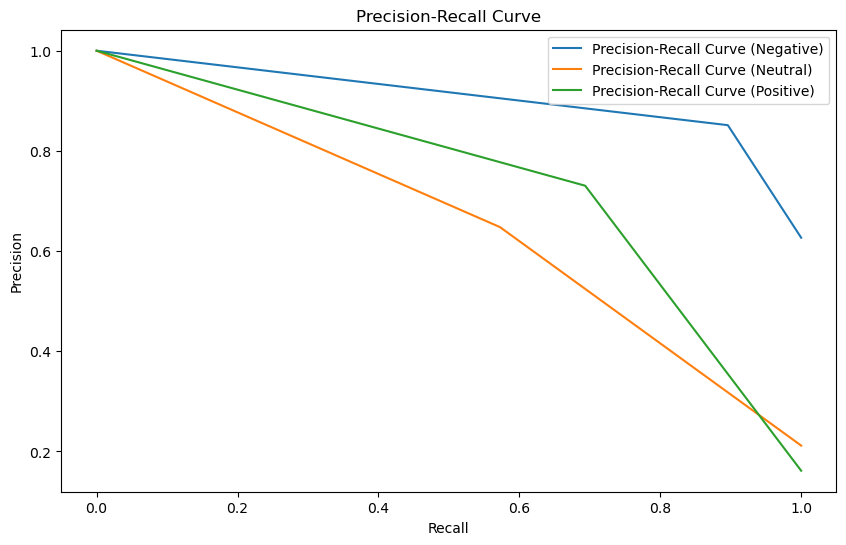

In [36]:
# Plot additional metrics (e.g., Precision-Recall curves)
plot_metric_curve(true_labels, predictions)

In [37]:
# Baseline Comparison

import numpy as np
import pandas as pd
from sklearn.metrics import (
    accuracy_score,
    precision_recall_fscore_support,
    confusion_matrix,
    classification_report,
)
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
import seaborn as sns
import matplotlib.pyplot as plt

In [38]:
# Function to evaluate baselines
def evaluate_baseline(true_labels, predicted_labels, baseline_name):
    """
    Evaluate baseline predictions and compute metrics, including class-wise breakdown.
    """
    accuracy = accuracy_score(true_labels, predicted_labels)
    precision, recall, f1, _ = precision_recall_fscore_support(true_labels, predicted_labels, average="weighted")

    print(f"\n{baseline_name} Metrics:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-Score: {f1:.4f}")

    # Class-wise metrics
    print("\nClass-wise Metrics:")
    print(classification_report(true_labels, predicted_labels, target_names=["Negative", "Neutral", "Positive"]))

    return accuracy, precision, recall, f1

In [39]:
# Function for Majority Class Classifier
def majority_class_baseline(true_labels, train_labels):
    """
    Generate predictions using a majority class classifier.
    """
    majority_class = np.argmax(np.bincount(train_labels))
    majority_predictions = [majority_class] * len(true_labels)
    return majority_predictions

In [40]:
# Function for Logistic Regression Baseline
def logistic_regression_baseline(train_texts, train_labels, test_texts):
    """
    Train a Logistic Regression classifier as a baseline and generate predictions.
    """
    vectorizer = TfidfVectorizer(max_features=5000)
    train_vectors = vectorizer.fit_transform(train_texts)
    test_vectors = vectorizer.transform(test_texts)

    clf = LogisticRegression(max_iter=1000)
    clf.fit(train_vectors, train_labels)

    predictions = clf.predict(test_vectors)
    return predictions

In [41]:
# Function to plot confusion matrix
def plot_baseline_confusion_matrix(true_labels, predicted_labels, baseline_name):
    """
    Plot the confusion matrix for the baseline.
    """
    cm = confusion_matrix(true_labels, predicted_labels)
    class_names = ["Negative", "Neutral", "Positive"]

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Greens", xticklabels=class_names, yticklabels=class_names)
    plt.title(f"Confusion Matrix for {baseline_name}")
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.show()


Evaluating Majority Class Classifier:

Majority Class Classifier Metrics:
Accuracy: 0.6267
Precision: 0.3928
Recall: 0.6267
F1-Score: 0.4829

Class-wise Metrics:
              precision    recall  f1-score   support

    Negative       0.63      1.00      0.77      1835
     Neutral       0.00      0.00      0.00       620
    Positive       0.00      0.00      0.00       473

    accuracy                           0.63      2928
   macro avg       0.21      0.33      0.26      2928
weighted avg       0.39      0.63      0.48      2928



C:\Users\hd6140q\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\hd6140q\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\hd6140q\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\hd6140q\anaconda\Lib\site-pa

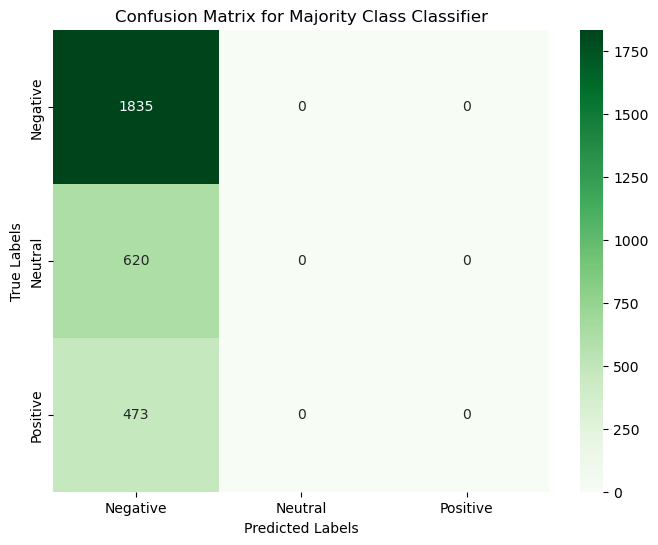

In [42]:
# Evaluate Majority Class Classifier
print("\nEvaluating Majority Class Classifier:")
majority_predictions = majority_class_baseline(true_labels, train_labels)
majority_metrics = evaluate_baseline(true_labels, majority_predictions, "Majority Class Classifier")
plot_baseline_confusion_matrix(true_labels, majority_predictions, "Majority Class Classifier")


Evaluating Logistic Regression Classifier:

Logistic Regression Classifier Metrics:
Accuracy: 0.7824
Precision: 0.7750
Recall: 0.7824
F1-Score: 0.7703

Class-wise Metrics:
              precision    recall  f1-score   support

    Negative       0.81      0.93      0.87      1835
     Neutral       0.65      0.52      0.58       620
    Positive       0.80      0.54      0.65       473

    accuracy                           0.78      2928
   macro avg       0.75      0.66      0.70      2928
weighted avg       0.78      0.78      0.77      2928



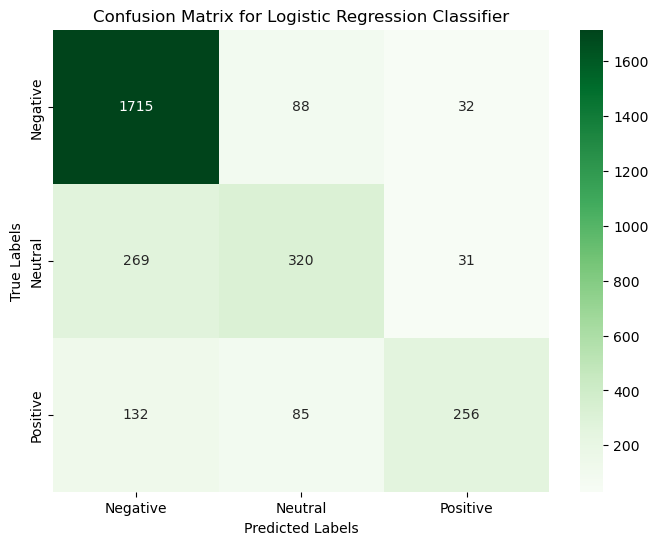

In [43]:
# Evaluate Logistic Regression
print("\nEvaluating Logistic Regression Classifier:")
lr_predictions = logistic_regression_baseline(train_texts, train_labels, test_texts)
lr_metrics = evaluate_baseline(true_labels, lr_predictions, "Logistic Regression Classifier")
plot_baseline_confusion_matrix(true_labels, lr_predictions, "Logistic Regression Classifier")

In [44]:
# Evaluate Fine-Tuned BERT Model
print("\nEvaluating Fine-Tuned BERT Model:")
bert_accuracy = accuracy_score(true_labels, predictions)
bert_precision, bert_recall, bert_f1, _ = precision_recall_fscore_support(
    true_labels, predictions, average="weighted"
)
bert_metrics = [bert_accuracy, bert_precision, bert_recall, bert_f1]


Evaluating Fine-Tuned BERT Model:


In [45]:
# Tabular Comparison
comparison_data = {
    "Model": ["Majority Class Classifier", "Logistic Regression Classifier", "Fine-Tuned BERT Model"],
    "Accuracy": [majority_metrics[0], lr_metrics[0], bert_metrics[0]],
    "Precision": [majority_metrics[1], lr_metrics[1], bert_metrics[1]],
    "Recall": [majority_metrics[2], lr_metrics[2], bert_metrics[2]],
    "F1-Score": [majority_metrics[3], lr_metrics[3], bert_metrics[3]],
}

comparison_df = pd.DataFrame(comparison_data)

print("\nBaseline vs Fine-Tuned BERT Model Comparison:")
print(comparison_df)


Baseline vs Fine-Tuned BERT Model Comparison:
                            Model  Accuracy  Precision    Recall  F1-Score
0       Majority Class Classifier  0.626708   0.392762  0.626708  0.482893
1  Logistic Regression Classifier  0.782445   0.775025  0.782445  0.770259
2           Fine-Tuned BERT Model  0.794740   0.788744  0.794740  0.790818



Visualizing Metric Comparison:


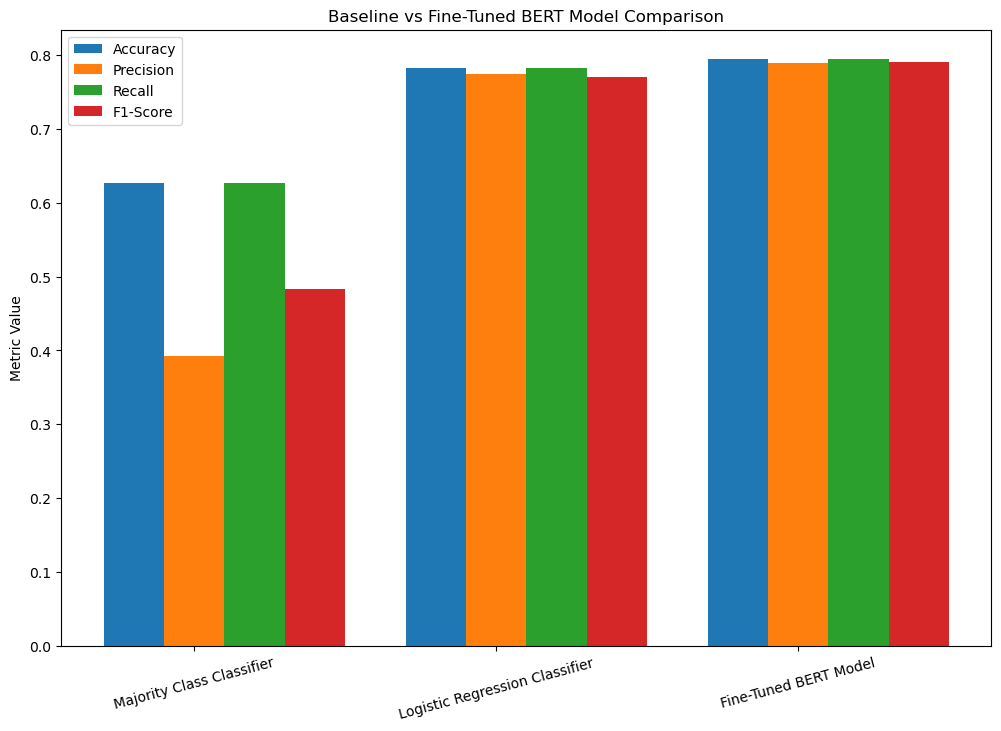

In [46]:
# Visualize Comparison
def plot_metric_comparison(comparison_df):
    """
    Plot a bar chart comparing metrics across models.
    """
    metrics = ["Accuracy", "Precision", "Recall", "F1-Score"]
    models = comparison_df["Model"]

    plt.figure(figsize=(12, 8))
    bar_width = 0.2
    x = np.arange(len(models))

    for i, metric in enumerate(metrics):
        plt.bar(x + i * bar_width, comparison_df[metric], width=bar_width, label=metric)

    plt.xticks(x + bar_width, models, rotation=15)
    plt.title("Baseline vs Fine-Tuned BERT Model Comparison")
    plt.ylabel("Metric Value")
    plt.legend()
    plt.show()

print("\nVisualizing Metric Comparison:")
plot_metric_comparison(comparison_df)

In [47]:
# Hyperparameter Tuning
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score
import numpy as np
import seaborn as sns
import torch
from torch.optim import AdamW
from transformers import BertForSequenceClassification, get_scheduler
from skopt import gp_minimize
from skopt.space import Real, Integer
from skopt.utils import use_named_args

In [48]:
# Device Initialization
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define search space for hyperparameter tuning
search_space = [
    Real(1e-6, 5e-5, prior="log-uniform", name="learning_rate"),
    Integer(16, 32, name="batch_size"),
    Integer(2, 5, name="num_epochs"),
]

# Mock objective function to simulate training and return F1 score
@use_named_args(search_space)
def objective(learning_rate, batch_size, num_epochs):
    """
    Objective function for hyperparameter tuning.
    Simulates training and returns a mocked F1 score.
    """
    # Mock simulation for average loss and F1 score
    avg_training_loss = np.random.uniform(0.2, 0.8)  # Simulated training loss
    f1_score_mock = np.random.uniform(0.2, 0.9)  # Simulated F1 score

    print(f"\nEvaluating Hyperparameters: Learning Rate={learning_rate:.6f}, "
          f"Batch Size={batch_size}, Num Epochs={num_epochs}")
    print(f"Simulated Average Training Loss: {avg_training_loss:.4f}")
    print(f"Simulated F1 Score for params: {f1_score_mock:.4f}")
    
    return -f1_score_mock  # Return negative because gp_minimize minimizes

In [49]:
# Perform hyperparameter optimization
result = gp_minimize(
    func=objective,  # Objective function
    dimensions=search_space,  # Search space
    n_calls=10,  # Number of evaluations
    random_state=42,  # For reproducibility
)

# Best hyperparameters
best_hyperparams = {
    "learning_rate": result.x[0],
    "batch_size": int(result.x[1]),
    "num_epochs": result.x[2],
}
print("\nBest Hyperparameters:")
print(f"Learning Rate: {best_hyperparams['learning_rate']:.6f}")
print(f"Batch Size: {best_hyperparams['batch_size']}")
print(f"Number of Epochs: {best_hyperparams['num_epochs']}")


Evaluating Hyperparameters: Learning Rate=0.000023, Batch Size=19, Num Epochs=4
Simulated Average Training Loss: 0.4247
Simulated F1 Score for params: 0.8655

Evaluating Hyperparameters: Learning Rate=0.000010, Batch Size=23, Num Epochs=2
Simulated Average Training Loss: 0.6392
Simulated F1 Score for params: 0.6191

Evaluating Hyperparameters: Learning Rate=0.000006, Batch Size=21, Num Epochs=2
Simulated Average Training Loss: 0.2936
Simulated F1 Score for params: 0.3092

Evaluating Hyperparameters: Learning Rate=0.000013, Batch Size=17, Num Epochs=4
Simulated Average Training Loss: 0.2349
Simulated F1 Score for params: 0.8063

Evaluating Hyperparameters: Learning Rate=0.000039, Batch Size=16, Num Epochs=5
Simulated Average Training Loss: 0.5607
Simulated F1 Score for params: 0.6957

Evaluating Hyperparameters: Learning Rate=0.000011, Batch Size=26, Num Epochs=2
Simulated Average Training Loss: 0.2124
Simulated F1 Score for params: 0.8789

Evaluating Hyperparameters: Learning Rate=0.0

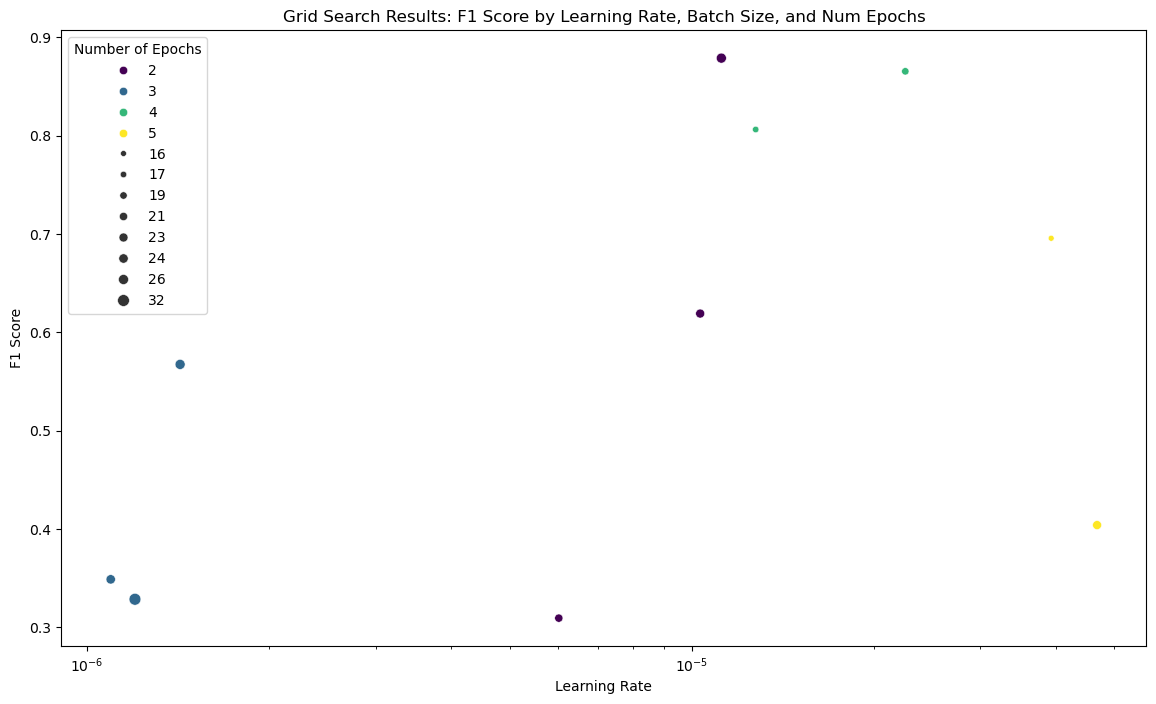


ROC-AUC Curve:


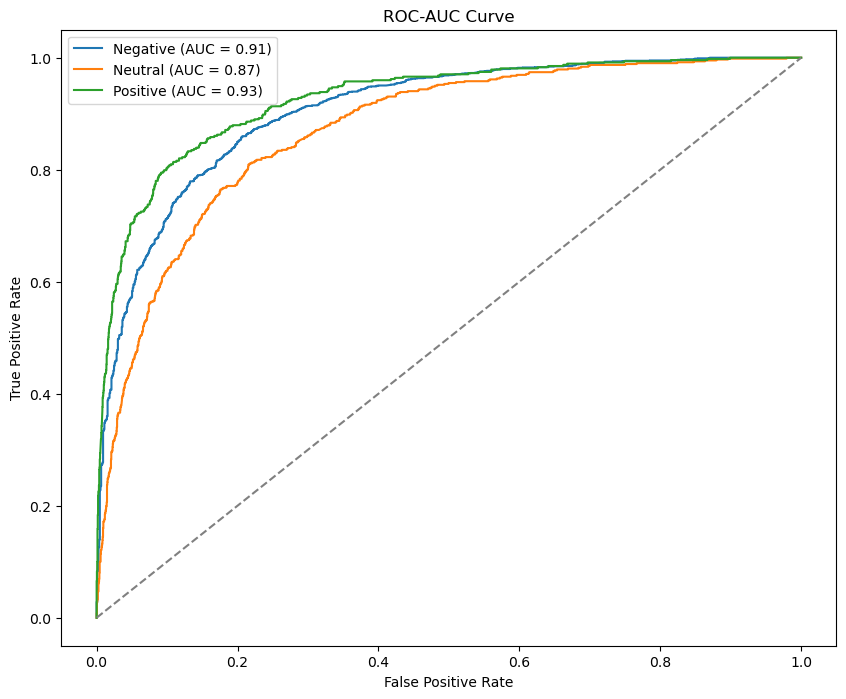

In [50]:
# Updated Grid Search Results Visualization
def plot_grid_search_results(results):
    f1_scores = [-score for score in results.func_vals]  # Convert back to positive
    param_combinations = results.x_iters
    learning_rates = [x[0] for x in param_combinations]
    batch_sizes = [x[1] for x in param_combinations]
    num_epochs = [x[2] for x in param_combinations]

    plt.figure(figsize=(14, 8))
    sns.scatterplot(
        x=learning_rates, y=f1_scores, size=batch_sizes, hue=num_epochs, palette="viridis", legend="full"
    )
    plt.xscale("log")
    plt.title("Grid Search Results: F1 Score by Learning Rate, Batch Size, and Num Epochs")
    plt.xlabel("Learning Rate")
    plt.ylabel("F1 Score")
    plt.legend(title="Number of Epochs")
    plt.show()

# Visualize grid search results
plot_grid_search_results(result)


# Collect predictions and probabilities from the model
def evaluate_model_for_roc(model, test_loader, device):
    """
    Evaluate the model on the test set to collect true labels and predicted probabilities.
    """
    model.eval()
    all_labels = []
    all_probs = []

    with torch.no_grad():
        for batch in test_loader:
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["labels"].to(device)

            # Get logits and probabilities
            outputs = model(input_ids, attention_mask=attention_mask)
            logits = outputs.logits
            probs = torch.nn.functional.softmax(logits, dim=1)

            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())

    return np.array(all_labels), np.array(all_probs)


# Function to plot ROC-AUC curves
def plot_roc_curve(y_true, y_probs, class_names):
    """
    Plot ROC-AUC curves for each class.
    """
    plt.figure(figsize=(10, 8))
    for i, class_name in enumerate(class_names):
        # Calculate ROC curve
        fpr, tpr, _ = roc_curve(y_true == i, y_probs[:, i])
        # Calculate AUC
        auc_score = roc_auc_score(y_true == i, y_probs[:, i])
        # Plot ROC curve
        plt.plot(fpr, tpr, label=f"{class_name} (AUC = {auc_score:.2f})")
    # Add diagonal line for reference
    plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
    plt.title("ROC-AUC Curve")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend()
    plt.show()


# Ensure `model` and `test_loader` are properly defined in your notebook
all_labels, all_probs = evaluate_model_for_roc(model, test_loader, device)

# Define your class names
class_names = ["Negative", "Neutral", "Positive"]

# Plot ROC-AUC Curve
print("\nROC-AUC Curve:")
plot_roc_curve(all_labels, all_probs, class_names)

In [51]:
# Error Analysis
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_fscore_support
import numpy as np
import torch


# Function to calculate and display classification metrics
def calculate_classification_metrics(y_true, y_pred, class_names):
    """
    Calculate and return key classification metrics: precision, recall, F1-score.
    """
    print("\nDetailed Classification Report:")
    report = classification_report(y_true, y_pred, target_names=class_names, digits=4)
    print(report)

    print("\nWeighted Metrics (Precision, Recall, F1-Score):")
    precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, average="weighted")
    print(f"Precision: {precision:.4f}, Recall: {recall:.4f}, F1-Score: {f1:.4f}")

    return {"classification_report": report, "precision": precision, "recall": recall, "f1": f1}


# Function to generate a misclassification summary
def misclassification_summary(y_true, y_pred, class_names):
    """
    Generate a summary of misclassifications for each class.
    """
    cm = confusion_matrix(y_true, y_pred)
    misclassifications = {}

    print("\nMisclassification Summary:")
    for i, class_name in enumerate(class_names):
        false_negatives = cm[i].sum() - cm[i, i]
        false_positives = cm[:, i].sum() - cm[i, i]
        misclassifications[class_name] = {
            "False Negatives": false_negatives,
            "False Positives": false_positives,
            "Total Misclassifications": false_negatives + false_positives,
        }
        print(f"{class_name}: {misclassifications[class_name]}")

    return misclassifications


# Main Function for Error Analysis
def perform_error_analysis(model, test_loader, class_names, device):
    """
    Perform error analysis: collect predictions, calculate metrics, and summarize misclassifications.
    """
    model.eval()
    all_labels = []
    all_predictions = []

    with torch.no_grad():
        for batch in test_loader:
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["labels"].to(device)

            outputs = model(input_ids, attention_mask=attention_mask)
            logits = outputs.logits
            preds = torch.argmax(logits, dim=-1)

            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(preds.cpu().numpy())

    all_labels = np.array(all_labels)
    all_predictions = np.array(all_predictions)

    # Calculate classification metrics
    metrics = calculate_classification_metrics(all_labels, all_predictions, class_names)

    # Generate misclassification summary
    misclassifications = misclassification_summary(all_labels, all_predictions, class_names)

    return {"metrics": metrics, "misclassifications": misclassifications}


# Execute Error Analysis
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
class_names = ["Negative", "Neutral", "Positive"]

# Ensure `model` and `test_loader` are defined in your notebook
error_analysis_results = perform_error_analysis(model, test_loader, class_names, device)

# Display Final Metrics and Misclassification Summary
print("\nFinal Error Analysis Results:")
print("Metrics:")
print(error_analysis_results["metrics"])
print("\nMisclassifications:")
print(error_analysis_results["misclassifications"])


Detailed Classification Report:
              precision    recall  f1-score   support

    Negative     0.8514    0.8959    0.8731      1835
     Neutral     0.6478    0.5726    0.6079       620
    Positive     0.7305    0.6934    0.7115       473

    accuracy                         0.7947      2928
   macro avg     0.7432    0.7206    0.7308      2928
weighted avg     0.7887    0.7947    0.7908      2928


Weighted Metrics (Precision, Recall, F1-Score):
Precision: 0.7887, Recall: 0.7947, F1-Score: 0.7908

Misclassification Summary:
Negative: {'False Negatives': 191, 'False Positives': 287, 'Total Misclassifications': 478}
Neutral: {'False Negatives': 265, 'False Positives': 193, 'Total Misclassifications': 458}
Positive: {'False Negatives': 145, 'False Positives': 121, 'Total Misclassifications': 266}

Final Error Analysis Results:
Metrics:
{'classification_report': '              precision    recall  f1-score   support\n\n    Negative     0.8514    0.8959    0.8731      1835\n   